# UMAP : Uniform Manifold Approximation

We will ask and answer the following questions: 
- What is UMAP?
- Is a train/test separation necessary?
- On which variables shall we focus?
- PCA vs UMAP: what are the differences?

## What is UMAP ?
UMAP is a non-linear dimensionality reduction method designed to preserve structure of a dataset viewed as lying on a manifold. UMAP’s practical aim is producing an embedding useful for visualization (competitive with t‑SNE but often faster and more scalable).

It is an appropriate exploratory tool here because it can reveal non-linear local structure (listing “archetypes” and neighborhood relationships). UMAP is best interpreted as neighborhood structure (who is closed to whom) not as interpretable axes or exact inter-cluster distances.
It is most reliable for statements about local neighborhoods. If two points are close in the UMAP embedding, they should look close in the original feature space.

UMAP is not reliable for axis or distance interpretations: 
- Axes are not interpretable because UMAP coordinates are not tied to linear combinations of original
features and can rotate without changing the solution quality.
- Distances between separated clusters can be visually meaningful, but should not be treated as
precise “how far apart segments are” in the original high-dimensional space

### The importance of the parameters : 
- n_neighbors (local vs global trade-off): it controls neighborhood size used to approximate the manifold. Smaller values emphasize local structure; larger values promote more global coherence.
- min_dist (how “clumpy” clusters appear): Sets the minimum distance between points in the low-dimensional embedding; smaller values allow tighter packing and visually “clumpier” embeddings; larger values spread points out.
- metric: it defines how distances are computed in the original space (can whange whether it is a binary or continuous space)


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

In [6]:
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset introuvable : {data_path}")
df = pd.read_csv(data_path, compression='gzip')
print(df.columns.tolist())


['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']


These are all our variables. As it will be presented later, we will use UMAP on several variables to obtain different visualization of our dataset, depending on the price, the location...

Separation of the features X and the target Y. UMAP is a unsupervised machhine learning method – such as t-SNE or PCA –, so we need to supress any link between features and target variables.

In [ ]:
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])
# Target_class is constructed from price_clean (discretized price) so we drop it to avoid data leakage

print(f"\nFeatures (X) : {X.shape[1]} colonnes")
print(f"Target (y) : {len(y)} valeurs")
print(f"\nDistribution des classes :")
print(y.value_counts().sort_index())


Features (X) : 27 colonnes
Target (y) : 73111 valeurs

Distribution des classes :
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64


## Train/test split ? 

#### Case A: UMAP for exploratory visualization only

If UMAP is only used to understand structure, we can either :
- Compute it on the full dataset (or a sample of it):
- color by target or metadata
an then interpret neighborhoods qualitatively. In this case, train/test split is optional; its main value is in checking whether the same structures appear across subsets (stability). The important rule is still to avoid leakage variables if you we are interpreting with respect to the target.


#### Case B: UMAP as a transformer inside an ML pipeline

To train a classifier/regressor on top of UMAP coordinates, we must “fit on train only” to avoid leakage.
We split first and preprocessing it on train only. Then, we transform test (e.g., scaler fit on train) and it UMAP on transformed train only
- Use reducer.transform(X_test_transformed) to embed the test set.
- Train the downstream model on the train embedding and evaluate on the test embedding.

This avoids contaminating evaluation with information that would not exist at prediction time (a core
scikit-learn “common pitfalls” warning).



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=123
)  

We stratify to maintain the same class distribution in train and test: when we split the dataset into train and test, we want to ensure that the proportion of each class in the target variable is maintained in both sets. 

Important when dealing with imbalanced datasets, where some classes may be underrepresented. By using stratify=y, distribution of classes in train and test reflects the distribution in the original dataset.

### UMAP on train 

For methods based on distances (like UMAP), it's crucial to standardize the features to ensure that all features contribute equally to the distance calculations. Otherwise, features with larger scales could dominate (via the variance) the distance metrics, leading to skewed results.

We also limit to 10k samples for UMAP to avoid long computation times and memory issues, while still capturing the overall structure of the data.

Sous-échantillonnage pour UMAP : 10000 samples


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


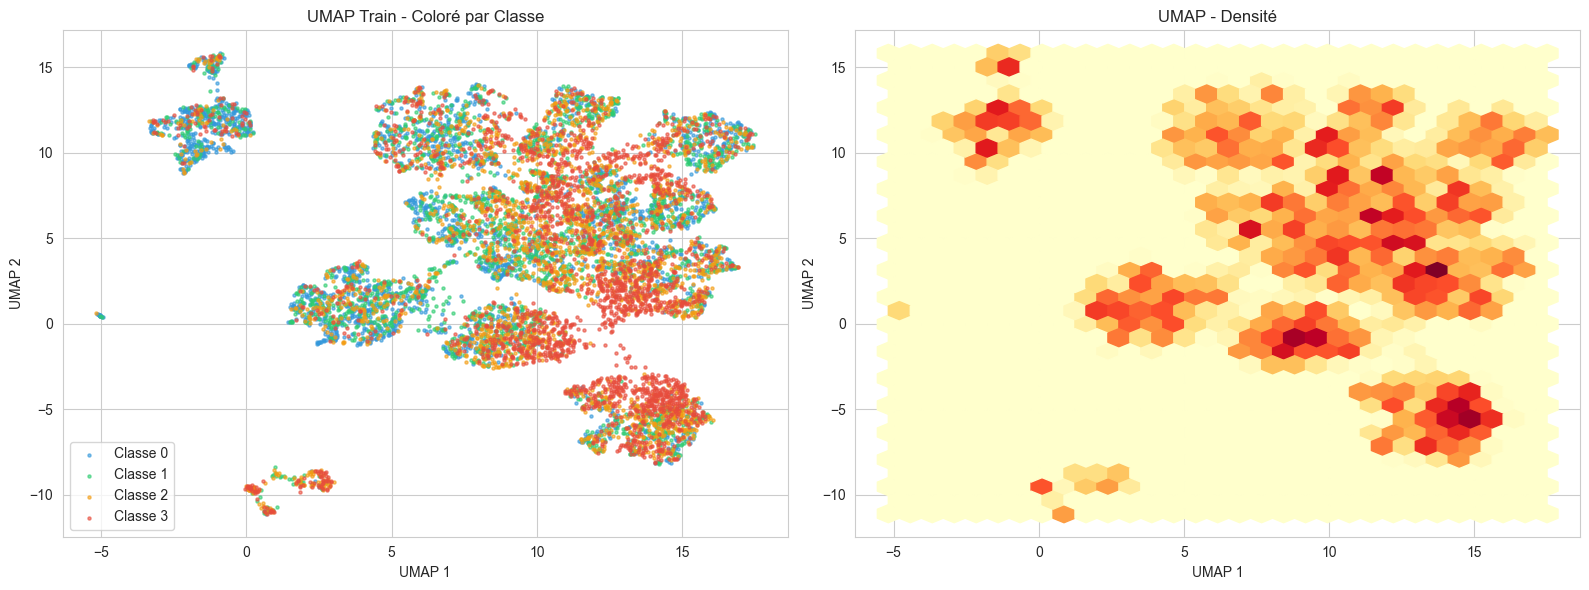

In [ ]:

scaler_pca = StandardScaler() 
X_train_std = scaler_pca.fit_transform(X_train)

rng = np.random.default_rng(42) #for reproducibility and stability across runs

sample_size = min(10000, len(X_train)) 
if len(X_train) > sample_size:
    print(f"Subsamples for UMAP : {sample_size} samples")
    indices = rng.choice(len(X_train), sample_size, replace=False)
    X_train_sample = X_train_std[indices]
    y_train_sample = y_train.iloc[indices]
else:
    X_train_sample = X_train_std
    y_train_sample = y_train

reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, random_state=42, verbose=False)
embedding_train = reducer.fit_transform(X_train_sample)

# Visualisations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Coloré par classe
colors_class = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
for classe in range(4):
    mask = y_train_sample == classe
    axes[0].scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
                   c=colors_class[classe], label=f'Classe {classe}', s=5, alpha=0.6)
axes[0].set_title("UMAP Train - Coloré par Classe")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].legend()

# Densité
axes[1].hexbin(embedding_train[:, 0], embedding_train[:, 1], gridsize=30, cmap='YlOrRd')
axes[1].set_title("UMAP - Densité")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

Note: x-axis and y-axis are not interpretable for UMAP (unlike PCA) --> the dimensions can be inversed 
UMAP is usedn

## What is the added value of UMAP compared to PCA?

PCA: linear projection --> components are interpretable “PC1 is driven by these variables" and
quantifiable “PC1+PC2 explain X% variance.”

UMAP : non-linear and neighborhood-driven --> not an “explained variance” curve

UMAP’s advantage is local structure discovery: 

Here, in this tabular, we have a mixed of continuous and binary variables. The relationships between variables can be non-linear (e.g. room type × capacity × amenities × location). UMAP can reveal non-linear grouping patterns when similarity is not well-modeled by linear directions (such as here in this specific tabular).  

A nonlinear method can reveal sub-populations (“islands”) that PCA sometimes spreads out into elongated shapes, because PCA does not “bend” the space: it only projects it. 

Therefore, it is better to use PCA to interpret the main linear factors and explain the overall structure and use UMAP to visualize local nonlinear patterns, identify archetypes/outliers, and check whether the price classes seem to overlap strongly or not.



### On which feature can we do UMAP? 

The key principle is to choose subsets that support an interpretive question and we shall recall that UMAP is sensitive to the distance metric.

- Full explanatory set as a recommended baseline: UMAP is mainly used as an unsupervised method. So, we include all variables without distinguishing target/features.
- Location and market proxies: dist_to_center, neigh_popularity, number_of_reviews, minimum_nights_avg_ntm --> Focuses on spatial/market dynamics; often yields gradients rather than discrete clusters
- Capacity & configuration: accommodates, bedrooms, beds, bathrooms_qty --> Tests whether listing “size” alone
forms clear archetypes and how it relates to target_class.
- 


Relevance of UMAP

Useful for exploration / diagnosis but not really as a feature-engineering step for the final predictor :

- EDA / sanity checks: 
Non-linear dimensionality reduction method --> used for visualization and exploring structure (clusters, outliers...): to see whether the quartile classes overlap heavily (hard classification problem) or separate somewhat (easier).

- Detecting weird outliers: 
Isolated islands --> groups like “luxury + big apartments”, “tiny studios” : useful for cleaning and feature design—even 

UMAP isn’t necessary because not a high-dimensional regime where dimensionality reduction is crucial: 

- Tree-based models are stronger at learning non-linear interactions directly from the original features --> compressing features often brings little benefit as UMAP is not primarily designed as a supervised predictor.